In [1]:
import polars as pl
from plotnine import *

In [2]:
# Gather SMF
smf = pl.read_csv('../../data/sra/microbial_fractions.with_ave_genome_size.csv.gz', has_header=True, separator='\t')
smf[:3]

sample,bacterial_archaeal_bases,metagenome_size,read_fraction,average_bacterial_archaeal_genome_size,warning
str,i64,f64,str,i64,str
"""SRR8634435""",1178752140,1.2550e9,"""93.92%""",3419746,null
"""SRR8640623""",1418455610,3.2740e9,"""43.32%""",1941733,null
"""SRR8692214""",7569181622,7.7290e9,"""97.93%""",3353276,null


In [3]:
# Filter rows based on NCBI method metadata
# ncbi_method <- read_delim("data/sra/NCBI_method_taxonomy_processed.csv.gz")
#   filter(library_strategy == "WGS" & library_selection == "RANDOM") %>%
#   filter(gbp > 0.5) 
extra_metadata = pl.read_csv('../../data/sra/extra_metadata_short.tsv.gz', separator='\t', null_values=['NA','null'])
# print(extra_metadata.shape)
# show_all(extra_metadata[:3])
extra_metadata = extra_metadata.filter(pl.col('library_strategy') == 'WGS').filter(pl.col('library_selection') == 'RANDOM').filter(pl.col('Gbp') > 0.5)
# print("Found {} SRA runs that pass the metadata filtering".format(extra_metadata.shape[0]))
original_smf_count = smf.shape[0]
smf = smf.join(extra_metadata, left_on='sample', right_on='run', how='inner')
print("Found {} SRA runs that pass the metadata filtering out of {} original".format(smf.shape[0], original_smf_count))

Found 136284 SRA runs that pass the metadata filtering out of 251919 original


# Parsing SRA metadata columns for filter size

In [4]:
fraction_metadata = pl.read_csv('frac_size_filter.csv')
fraction_metadata[:3]

key,value,acc
str,str,str
"""filter_fractio…","""3-20um""","""SRR13827121"""
"""size_fraction_…","""0.2""","""ERR2002429"""
"""size_fraction_…","""20""","""ERR2098396"""


In [5]:
# What keys are most common?
pl.Config.set_fmt_str_lengths(100)
fraction_metadata.groupby('key').count().sort(by='count')

/tmp/ipykernel_81749/488747873.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
/tmp/ipykernel_81749/488747873.py:3: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


key,count
str,u32
"""size_fraction_microns_sam""",12
"""filter_fraction_sam""",16
"""sample_protocol__size_fraction_upper_threshold_sam""",16
"""sample_protocol__size_fraction_lower_threshold_sam""",16
"""filter_fraction__um__sam""",37
"""sample_size_fraction_lower_threshold_sam""",97
"""sample_size_fraction_upper_threshold_sam""",97
"""size_fraction_sam""",193
"""size_frac_sam""",266


In [6]:
fraction_metadata.filter(pl.col('key')=='size_frac_sam').filter(pl.col('value') != 'NA').sample(n=10)

key,value,acc
str,str,str
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161547"""
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161555"""
"""size_frac_sam""","""> 0.7 um""","""SRR12347132"""
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161494"""
"""size_frac_sam""","""> 0.7 um""","""SRR12347137"""
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161574"""
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161568"""
"""size_frac_sam""","""0-0.45 micrometer""","""SRR9161501"""
"""size_frac_sam""","""0.2-0.02""","""SRR11932623"""


In [7]:
runs = set(smf['sample'])
f2 = fraction_metadata.filter(pl.col('value') != 'NA').filter(pl.col('acc').is_in(runs))
f2.shape, fraction_metadata.shape

((3803, 3), (7441, 3))

In [8]:
f2.groupby('key').count().sort(by='count')

/tmp/ipykernel_81749/51850140.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
/tmp/ipykernel_81749/51850140.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


key,count
str,u32
"""size_fraction_microns_sam""",11
"""filter_fraction__um__sam""",36
"""size_frac_sam""",47
"""sample_size_fraction_upper_threshold_sam""",83
"""sample_size_fraction_lower_threshold_sam""",83
"""size_fraction_sam""",115
"""size_fraction_upper_threshold_sam""",1670
"""size_fraction_lower_threshold_sam_s_dpl49""",1758


In [9]:
#f2.filter(pl.col('key')=='size_frac_sam').sample(n=10)

In [10]:
# (mambaforge)cl5n007:20240103:~/git/sandpiper/snakemake/prod/kingfisher_metadata/20220627$ grep -F 'marine metagenome' kingfisher_metadata.csv |cut -f1 >~/m/msingle/mess/149_read_fraction_marine_investigation/marine_metagenomes.list
marine_metagenomes = set(pl.read_csv('marine_metagenomes.list', has_header=False)['column_1'])
print(len(marine_metagenomes))
list(marine_metagenomes)[0]

13804


'SRR12480313'

In [11]:
f3 = fraction_metadata.filter(pl.col('value') != 'NA').filter(pl.col('acc').is_in(marine_metagenomes))
f3.groupby('key').count().sort(by='count')

/tmp/ipykernel_81749/851418040.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
/tmp/ipykernel_81749/851418040.py:2: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


key,count
str,u32
"""size_fraction_microns_sam""",12
"""sample_protocol__size_fraction_upper_threshold_sam""",16
"""sample_protocol__size_fraction_lower_threshold_sam""",16
"""filter_fraction__um__sam""",37
"""size_frac_sam""",38
"""size_fraction_sam""",92
"""sample_size_fraction_lower_threshold_sam""",97
"""sample_size_fraction_upper_threshold_sam""",97
"""size_fraction_upper_threshold_sam""",3286


In [12]:
# Are there any samples which haven't been differentiated with an upper filter (beyond getting rid of big stuff?)?
#f3.filter(pl.col('key').is_in(['size_fraction_microns_sam','size_frac_sam','filter_fraction__um__sam','size_fraction_sam'])).sample(n=10)

In [13]:
# First attempt conversion of the 2-column ones
import re
lower_bound_size_keys = [
    'sample_protocol__size_fraction_lower_threshold_sam',
    'sample_size_fraction_lower_threshold_sam',
    'size_fraction_lower_threshold_sam_s_dpl49'
]
upper_bound_size_keys = [
    'sample_protocol__size_fraction_upper_threshold_sam',
    'sample_size_fraction_upper_threshold_sam',
    'size_fraction_upper_threshold_sam'
]
lower_bounds_per_accession = []
upper_bounds_per_accession = []
fails = 0
for key in lower_bound_size_keys:
    n = 0
    for row in f3.filter(pl.col('key')==key).rows(named=True):
        val = row['value']
        um = None
        # print(row)
        if re.match(r'^[\d\\.]+$', val):
            um = float(val)
        elif match := re.match(r'^([\d\\.]+) {0,1}um$', val):
            um = float(match[1])
        elif val in ['<','>','extra_value_found','dissolved','not-provided','100KD']:
            # I guess these are badly entered / inappropriate / non-micrometre values, ignore them
            fails += 1
            continue
        else:
            print("unexpected value encountered: ", row['acc'], val)
            continue
        lower_bounds_per_accession.append({
            'acc': row['acc'],
            'lower_bound': um
        })

for key in upper_bound_size_keys:
    n = 0
    for row in f3.filter(pl.col('key')==key).rows(named=True):
        val = row['value']
        um = None
        # print(row)
        if re.match(r'^[\d\\.]+$', val):
            um = float(val)
        elif match := re.match(r'^([\d\\.]+) {0,1}um$', val):
            um = float(match[1])
        elif val in ['No prefiltration', 'no prefiltration', 'no size limit']:
            um = -1 # Recorded but not filtered
        elif match := re.match(r'^>([\d\\.]+)$', val):
            um = -float(match[1]) # Likely unfiltered, but need to match lower bound, so encode as negative for later parsing
        elif val in ['<','>','extra_value_found','dissolved','not-provided','100KD','not provided']:
            # I guess these are badly entered / inappropriate / non-micrometre values, ignore them
            fails += 1
            continue
        else:
            print("unexpected value encountered: ", row['acc'], val)
            continue
        upper_bounds_per_accession.append({
            'acc': row['acc'],
            'upper_bound': um
        })

fails, len(lower_bounds_per_accession), len(upper_bounds_per_accession)

(899, 3201, 2807)

In [14]:
# Now parse the single-entry samples
single_range_keys = [
"size_fraction_microns_sam",
"size_frac_sam",
"filter_fraction__um__sam",
"size_fraction_sam",
]

filtration_ranges = []
for key in single_range_keys:
    for row in f3.filter(pl.col('key')==key).rows(named=True):
        val = row['value']
        lower = None
        upper = None
        # print(row)
        if match := re.match(r'^([\d\\.]+) {0,1}- {0,1}([\d\\.]+) {0,1}(um|micrometer|µm)$', val):
            lower = float(match[1])
            upper = float(match[2])
        elif match := re.match(r'([\d\\._]+)_to_([\d\\.]+)_microns', val):
            # e.g. SRR1298808 0_3_to_3_microns
            lower = float(match[1].replace('_','.'))
            upper = float(match[2])
        elif match := re.match(r'^> {0,1}([\d\\.]+) {0,1}(um|micrometer|µm)$', val):
            # e.g. SRR12347133 > 0.7 um
            lower = float(match[1])
            upper = -1
        elif match := re.match(r'^([\d\\.]+) {0,1}â\?\? {0,1}([\d\\.]+)$', val):
            # e.g. SRR2053282 0.22 â?? 3
            lower = float(match[1])
            upper = float(match[2])
        elif match := re.match(r'^([\d\\.]+)\+ micrometer$', val):
            # e.g. ERR3256944 0.22+ micrometer
            lower = float(match[1])
            upper = -1
        elif val in ['<','>','extra_value_found','dissolved','not-provided','100KD','not provided']:
            # I guess these are badly entered / inappropriate / non-micrometre values, ignore them
            fails += 1
            continue
        else:
            print("unexpected value encountered: ", row['acc'], val)
            fails += 1
            continue
        filtration_ranges.append({
            'acc': row['acc'],
            'lower_bound': lower,
            'upper_bound': upper,
        })
fails, len(lower_bounds_per_accession), len(upper_bounds_per_accession), len(filtration_ranges)

unexpected value encountered:  SRR6663530 8
unexpected value encountered:  SRR11787837 0.2 micron
unexpected value encountered:  SRR11787098 85m_>30micron
unexpected value encountered:  SRR11786911 30m_>1.6micron


(903, 3201, 2807, 175)

In [15]:
# Put these ranges together
lower_and_upper = pl.DataFrame(lower_bounds_per_accession).join(pl.DataFrame(upper_bounds_per_accession), on='acc', how='inner')
final = pl.concat([
    lower_and_upper,
    pl.DataFrame(filtration_ranges)
])

# Convert negative values which should be the same as the lower except negative
bad_negatives = final.filter(pl.col('upper_bound') < 0).filter(pl.col('upper_bound') != -1).filter(pl.col('upper_bound') != -pl.col('lower_bound'))
if len(bad_negatives) != 0:
    raise Exception("Found negative upper bounds which don't match lower bounds: ", bad_negatives)

In [16]:
# Negative values should now verified, so set them all as -1
final = final.with_columns(pl.when(pl.col('upper_bound') < 0).then(-1).otherwise(pl.col('upper_bound')).alias('upper_bound'))
# final

# Some sanity checking - the lower should be less than upper, unless upper is -1 or negative
bad_ordering = final.filter(pl.col('upper_bound') != -1).filter(pl.col('lower_bound') > pl.col('upper_bound'))
if len(bad_ordering) != 0:
    raise Exception("Found lower bounds which are greater than upper bounds: ", bad_ordering)

In [17]:
# What did we end up with?
print('total filtered sample count', len(final))
print('num filtered samples without upper bound', len(final.filter(pl.col('upper_bound') == -1)))
final = final.with_columns((pl.col('lower_bound').cast(pl.Utf8) + '-' + pl.col('upper_bound').cast(pl.Utf8)).alias('size_range'))
pl.Config.set_tbl_rows(100)
print(final.groupby('size_range').count())

total filtered sample count 2724
num filtered samples without upper bound 104
shape: (26, 2)
┌──────────────┬───────┐
│ size_range   ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ 0.3-3.0      ┆ 6     │
│ 0.8-5.0      ┆ 463   │
│ 3.0-57.0     ┆ 6     │
│ 1.6-20.0     ┆ 1     │
│ 0.22-2.7     ┆ 50    │
│ 20.0--1.0    ┆ 11    │
│ 0.8-200.0    ┆ 5     │
│ 0.22-5.0     ┆ 23    │
│ 2.0-20.0     ┆ 2     │
│ 0.22-3.0     ┆ 387   │
│ 20.0-180.0   ┆ 446   │
│ 0.7--1.0     ┆ 15    │
│ 0.2-2.7      ┆ 22    │
│ 0.45-0.8     ┆ 21    │
│ 0.22-0.45    ┆ 19    │
│ 0.1-0.22     ┆ 21    │
│ 20.0-200.0   ┆ 15    │
│ 180.0-2000.0 ┆ 480   │
│ 3.0-20.0     ┆ 86    │
│ 5.0-20.0     ┆ 366   │
│ 0.22-1.6     ┆ 95    │
│ 0.0-0.22     ┆ 20    │
│ 2.7--1.0     ┆ 21    │
│ 0.8-3.0      ┆ 70    │
│ 0.8-20.0     ┆ 16    │
│ 0.22--1.0    ┆ 57    │
└──────────────┴───────┘


/tmp/ipykernel_81749/1876158445.py:6: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
/tmp/ipykernel_81749/1876158445.py:6: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


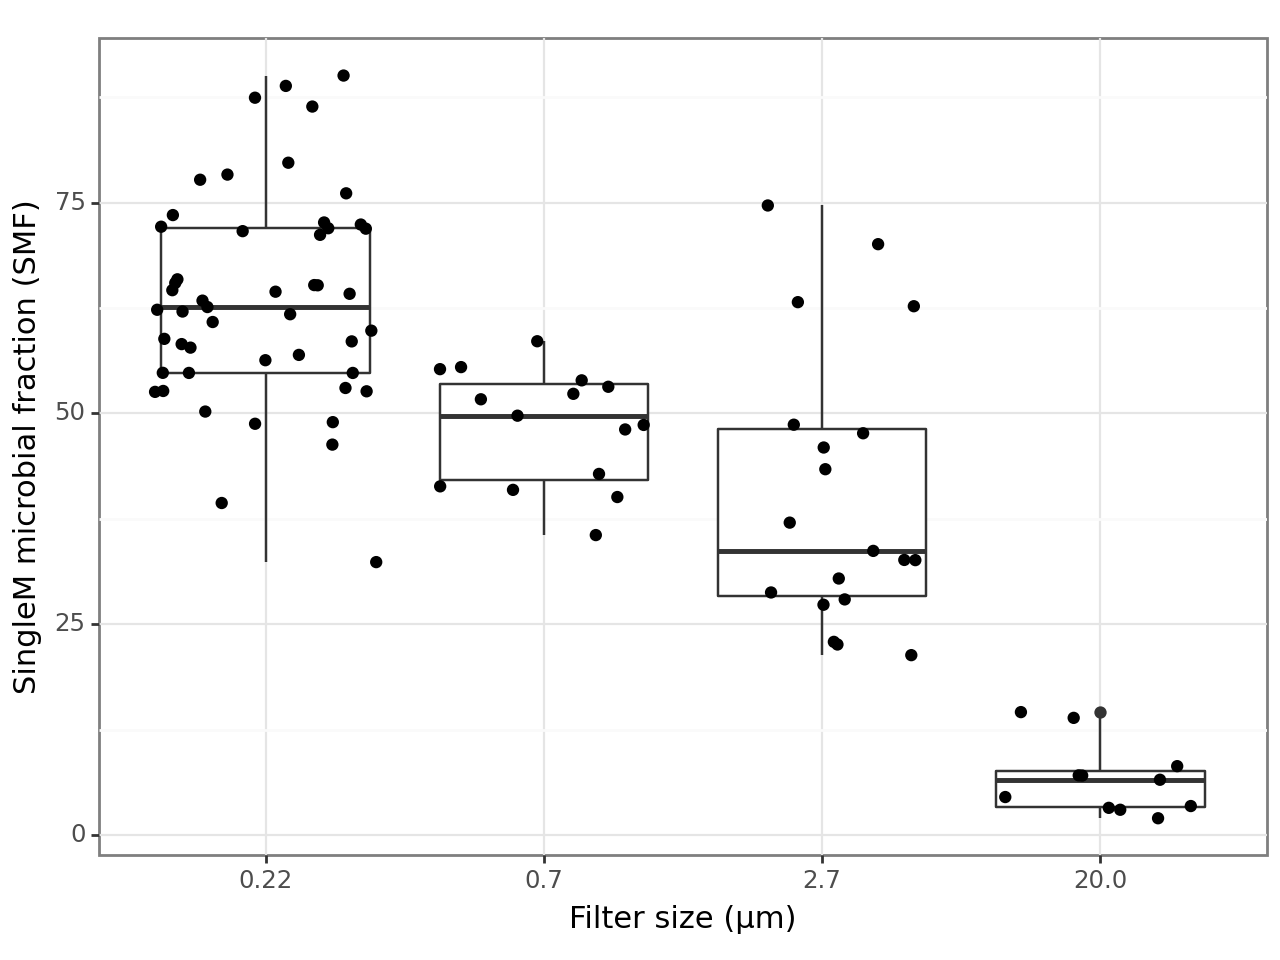

<Figure Size: (640 x 480)>

In [18]:
# OK, so now we can plot the SMF values of each of these. First the ones not filtered with an upper bound
non_uppers = smf.join(final.filter(pl.col('upper_bound') == -1), left_on='sample', right_on='acc', how='inner')
non_uppers = non_uppers.with_columns(pl.col('read_fraction').str.replace('%', '').cast(pl.Float64).alias('smf'))
ggplot(non_uppers.select([pl.col('lower_bound').cast(pl.Utf8), 'smf']))+geom_boxplot(aes(y='smf', x='lower_bound'))+geom_jitter(aes(y='smf', x='lower_bound')) + theme_bw() +xlab('Filter size (µm)') + ylab('SingleM microbial fraction (SMF)') #+ ggtitle('SMF of marine fitrations without an upper size limit')

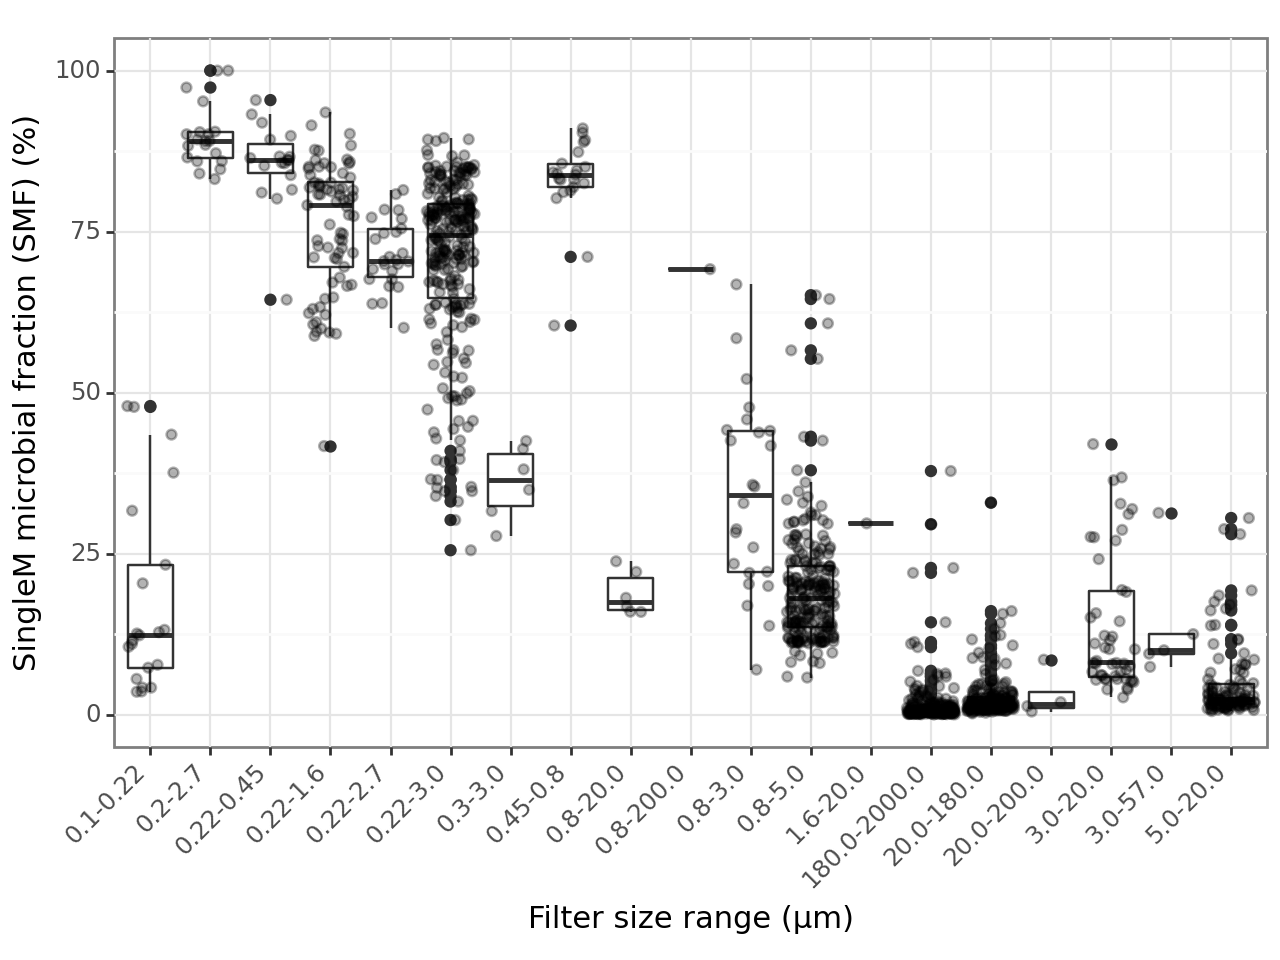

<Figure Size: (640 x 480)>

In [19]:
# And the rest of the ranges.
smf_ranges = smf.join(final.filter(pl.col('upper_bound') != -1), left_on='sample', right_on='acc', how='inner')
smf_ranges = smf_ranges.with_columns(pl.col('read_fraction').str.replace('%', '').cast(pl.Float64).alias('smf'))
ggplot(smf_ranges.select([pl.col('size_range').cast(pl.Utf8), 'smf']))+geom_boxplot(aes(y='smf', x='size_range'))+geom_jitter(aes(y='smf', x='size_range'), alpha=0.3) + theme_bw()+theme(axis_text_x = element_text(angle = 45, vjust = 1, hjust=1)) + xlab('Filter size range (µm)') + ylab('SingleM microbial fraction (SMF) (%)')

#  + ggtitle('SMF of marine fitrations with both an upper and lower size limit')

In [20]:
smf_ranges.write_csv('marine_smf_and_filter_sizes.csv')

In [21]:
ultrasmall = smf_ranges.filter(pl.col('size_range').is_in(['0.0-0.22','0.1-0.22']))
ultrasmall.select(pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

mean,sd,perc25,perc75,min,max
f64,f64,f64,f64,f64,f64
17.734286,14.937018,7.31,23.29,3.57,47.92


In [22]:
intermediate = smf_ranges.filter(pl.col('size_range').is_in(['0.22-3.0']))
intermediate.select(pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

mean,sd,perc25,perc75,min,max
f64,f64,f64,f64,f64,f64
70.697844,13.309668,64.62,79.32,25.54,89.55


In [23]:
larger = smf_ranges.filter(pl.col('lower_bound') >= 3)
larger.select(pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

mean,sd,perc25,perc75,min,max
f64,f64,f64,f64,f64,f64
3.731352,6.128917,0.75,3.55,0.06,42.02


In [24]:
# OK, so that seems good. But are we really sure that 0.22um only filters are not filtered first? Checking some

# non_uppers.filter(pl.col('lower_bound')==0.22).sort('sample')

# ERR2098366 - ERR2098377 # These ones are 0.22 lower, >0.22 upper. 
# https://www.nature.com/articles/s43705-023-00278-w#Sec2 For the analysis of the total volume of water collected: 1 L was filtered through a single cartridge membrane filter of 0.22 µm; 2.5 L through a single cartridge membrane filter of 0.22 µm; 10 L through a single flat membrane filter of 0.22 µm. For the size fractions analysis, microbes were collected by serial filtration through three filters of decreasing pore sizes, according to the following procedures: 10 L through a mesh filter of 20 µm followed by 3 µm and 0.22 µm flat membrane filters; 100 L through a mesh filter of 20 µm, followed by flat membrane filters of 3 µm and 0.22 µm. All filters were flash-frozen in liquid nitrogen and stored in a freezer at −80 °C.
# For other ones e.g. https://sandpiper.qut.edu.au/run/ERR2098382 it seems they did the right thing, so we are on the money here, I think.

# ERR3256944- size fraction 0.22+ micrometer. There's some pubs but not enough data, and GaII sequencing, so eh.

# ERR4674036 - ERR4674767 -	sample size fraction upper threshold: No prefiltration 
# Shotgun metagenome sequencing from the Ocean Sampling Day (OSD) campaign June 2018
#
# Can't find any publications for these samples, though (only 2015/2016 ones, before the sampling in 2018 - maybe this is unpublished data?)


In [25]:
# (mambaforge)cl5n007:20240104:~/git/sandpiper/snakemake/prod/kingfisher_metadata/20220627$ cut -f1,2 kingfisher_metadata.csv >~/m/msingle/mess/149_read_fraction_marine_investigation/runs_and_bioprojects.csv
runs_and_bioprojects = pl.read_csv('../../data/sra/runs_and_bioprojects.csv.gz',separator='\t')
runs_and_bioprojects[:3]

run,bioproject
str,str
"""DRR000713""","""PRJDA53873"""
"""DRR000714""","""PRJDA53873"""
"""DRR001356""","""PRJDA72415"""


In [26]:
# show_all(non_uppers[:3]), runs_and_bioprojects[:3]

In [27]:
# non_uppers2 = non_uppers.select(pl.exclude('bioproject_right')).join(runs_and_bioprojects.select(pl.exclude('bioproject_right')), left_on='sample', right_on='run', how='inner')

# # OSD 2018 is PRJEB40760
# # Pascoal et. al. sampling comparison is PRJEB87662
# project_names = pl.DataFrame([
#     {'bioproject': 'PRJEB87662', 'project': 'Pascoal et. al. sampling comparison'},
#     {'bioproject': 'PRJEB40760', 'project': 'Ocean Sampling Day 2018'},
# ])
# non_uppers3 = non_uppers2.join(project_names, on='bioproject', how='outer')

# ggplot(non_uppers3.select([pl.col('lower_bound').cast(pl.Utf8), 'smf', 'project']))+geom_boxplot(aes(y='smf', x='lower_bound'))+geom_jitter(aes(y='smf', x='lower_bound', color='project')) + theme_bw() +xlab('Filter size (µm)') + ylab('SingleM microbial fraction (SMF)') #+ ggtitle('SMF of marine fitrations without an upper size limit')

In [28]:
# Calculate some stats for the maintext
# non_uppers3.filter(pl.col('lower_bound')==0.22).select(pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

# Overall amount of microbial fraction in marine metagenomes

In [29]:
# marines = pl.read_csv('marine_metagenomes.list', has_header=False)

In [30]:
# marines.columns = ['sample']
# marines_smf = marines.join(smf, on='sample')
# marines_smf = marines_smf.with_columns(pl.col('read_fraction').str.replace('%', '').cast(pl.Float64).alias('smf'))
# marines_smf.select(pl.mean('smf').alias('mean'), pl.std('smf').alias('sd'), pl.quantile('smf', 0.25).alias('perc25'), pl.quantile('smf', 0.75).alias('perc75'), pl.min('smf').alias('min'), pl.max('smf').alias('max'))

# Attempt to find citations for the marine metagenomes with size filters

In [32]:
# TARA https://www.science.org/doi/10.1126/science.1261359
# PRJEB87662 https://academic.oup.com/ismecommun/article-abstract/3/1/84/7584914
# PRJEB35627 https://www.pnas.org/doi/abs/10.1073/pnas.2010783117
# PRJNA273799 PubMed 26667648
# PRJNA326482 https://doi.org/10.1016/j.dsr2.2017.11.016 (and others, but one will do)
# smf_ranges.filter(~pl.col('sample_name_right').str.contains('TARA')).filter(~pl.col('bioproject').is_in([
#     'PRJEB87662','PRJEB35627','PRJNA273799','PRJNA326482'
# ]))